# Week 4: Handling Complex Images - Happy or Sad Dataset

In this assignment you will be using the happy or sad dataset, which contains 80 images of emoji-like faces, 40 happy and 40 sad.

Create a convolutional neural network that trains to 99.9% accuracy on these images,  which cancels training upon hitting this training accuracy threshold.

In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import zipfile
from os import path, getcwd, chdir
import shutil

## Load and explore the data

Begin by taking a look at some images of the dataset.

Notice that all the images are contained within the `./data/` directory. 

This directory contains two subdirectories `happy/` and `sad/` and each image is saved under the subdirectory related to the class it belongs to.

Sample happy image:


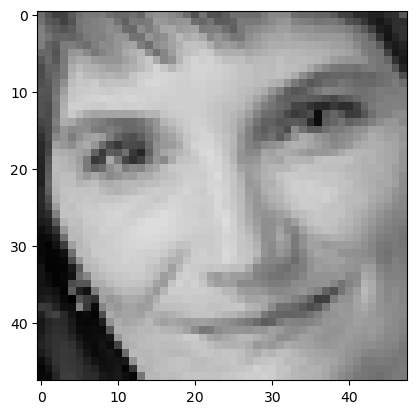


Sample sad image:


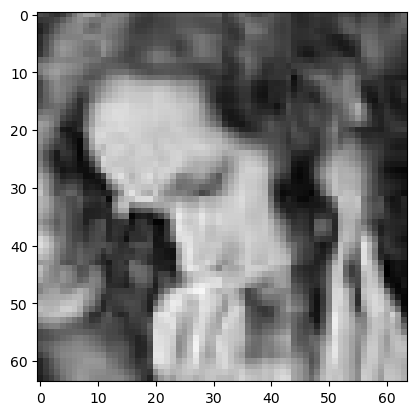

In [32]:
from tensorflow.keras.preprocessing.image import load_img

base_dir = "./data/"
train_dir = os.path.join(base_dir, "train/")
test_dir = os.path.join(base_dir, "test/")
val_dir = os.path.join(base_dir, "val/")

train_happy_dir = os.path.join(train_dir, "happy/")
train_sad_dir = os.path.join(train_dir, "sad/")

test_happy_dir = os.path.join(test_dir, "happy/")
test_sad_dir = os.path.join(test_dir, "sad/")

val_happy_dir = os.path.join(val_dir, "happy/")
val_sad_dir = os.path.join(val_dir, "sad/")

print("Sample happy image:")
plt.imshow(load_img(f"{os.path.join(test_happy_dir, os.listdir(test_happy_dir)[0])}"))
plt.show()

print("\nSample sad image:")
plt.imshow(load_img(f"{os.path.join(test_sad_dir, os.listdir(test_sad_dir)[0])}"))
plt.show()


It is cool to be able to see examples of the images to better understand the problem-space you are dealing with. 

However there is still some relevant information that is missing such as the resolution of the image (although matplotlib renders the images in a grid providing a good idea of these values) and the maximum pixel value (this is important for normalizing these values). For this you can use Keras as shown in the next cell:

In [33]:
from tensorflow.keras.preprocessing.image import img_to_array

# Load the first example of a happy face
sample_image  = load_img(f"{os.path.join(test_happy_dir, os.listdir(test_happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")


Each image has shape: (48, 48, 3)
The maximum pixel value used is: 221.0


Looks like the images have a resolution of 48X48. **This is very important because this will be the input size of the first layer in your network.** 

**The last dimension refers to each one of the 3 RGB channels that are used to represent colored images.**

In [34]:
print(f'total training happy images: {len(os.listdir(train_happy_dir))}')
print(f'total training sad images: {len(os.listdir(train_sad_dir))}')

print(f'total testing happy images: {len(os.listdir(test_happy_dir))}')
print(f'total testing sad images: {len(os.listdir(test_sad_dir))}')

print(f'total validation happy images: {len(os.listdir(val_happy_dir))}')
print(f'total validation sad images: {len(os.listdir(val_sad_dir))}')


total training happy images: 5052
total training sad images: 3389
total testing happy images: 1443
total testing sad images: 1728
total validation happy images: 721
total validation sad images: 536


## Defining the callback

Since you already have coded the callback responsible for stopping training (once a desired level of accuracy is reached) in the previous two assignments this time it is already provided so you can focus on the other steps:

In [35]:
# Please write your code only where you are indicated.
# please do not remove # model fitting inline comments.

DESIRED_ACCURACY = 0.999

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Change 'accuracy' to 'acc' for the Coursera autograder!
    if(logs.get('accuracy')>DESIRED_ACCURACY): 
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
        

A quick note on callbacks: 

So far you have used only the `on_epoch_end` callback but there are many more. For example you might want to check out the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback, which allows you to save the best weights for your model.

## Pre-processing the data

Keras provides great support for preprocessing image data. A lot can be accomplished by using the `ImageDataGenerator` class. Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) if you get stuck in the next exercise. In particular you might want to pay attention to the `rescale` argument when instantiating the `ImageDataGenerator` and to the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# GRADED FUNCTION: image_generator
def image_generator():
    ### START CODE HERE

    # Instantiate the ImageDataGenerator class.
    # Remember to set the rescale argument.
    train_datagen = ImageDataGenerator(rescale=1/255)


    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(150, 150),
                                                        batch_size=10,
                                                        class_mode='binary')
    

    return train_generator
    

In [37]:
# Save your generator in a variable
gen = image_generator()

Found 8441 images belonging to 2 classes.


**Expected Output:**
```
Found 8441 images belonging to 2 classes.
```

## Creating and training your model

Finally, complete the `train_happy_sad_model` function below. This function should return your  neural network.

**Your model should achieve an accuracy of 99.9% or more before 15 epochs to pass this assignment.**

**Hints:**
- You can try any architecture for the network but keep in mind that the model will work best with 3 convolutional layers. 


- In case you need extra help you can check out some tips at the end of this notebook.

In [43]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras.optimizers import RMSprop

# GRADED FUNCTION: train_happy_sad_model
def train_happy_sad_model(train_generator):

    # Instantiate the callback
    callbacks = myCallback()

    ### START CODE HERE

    # Define the model
    # This Code Block should Define and Compile the Model. Please assume the images are 150 X 150 in your implementation.
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('happy') and 1 for the other ('sad')
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # get the summary
    model.summary()

    # Compile the model
    # Select a loss function compatible with the last layer of your network
    model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])
    

    # Train the model
    # Your model should achieve the desired accuracy in less than 15 epochs.
    # You can hardcode up to 20 epochs in the function below but the callback should trigger before 15.
    history = model.fit_generator(
          train_generator,
          steps_per_epoch=8,
          epochs=40,
          verbose=1,
          callbacks=[callbacks])
    # model fitting
    # Change 'accuracy' to 'acc' for the Coursera autograder!
    # return history.history['accuracy'][-1]
    
    ### END CODE HERE
    return history

In [44]:
hist = train_happy_sad_model(gen)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 64)      

/var/folders/7p/nhr_8mz933v_4r1mwyd3_jg40000gp/T/ipykernel_91216/306539190.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


8/8 [==============================] - 1s 44ms/step - loss: 0.9915 - accuracy: 0.4125
Epoch 2/40
8/8 [==============================] - 0s 45ms/step - loss: 0.6789 - accuracy: 0.6375
Epoch 3/40
8/8 [==============================] - 0s 44ms/step - loss: 0.6666 - accuracy: 0.6125
Epoch 4/40
8/8 [==============================] - 0s 44ms/step - loss: 0.6922 - accuracy: 0.5250
Epoch 5/40
8/8 [==============================] - 0s 44ms/step - loss: 0.6453 - accuracy: 0.6375
Epoch 6/40
8/8 [==============================] - 0s 45ms/step - loss: 0.6488 - accuracy: 0.5500
Epoch 7/40
8/8 [==============================] - 0s 45ms/step - loss: 0.6426 - accuracy: 0.5875
Epoch 8/40
8/8 [==============================] - 0s 45ms/step - loss: 0.6734 - accuracy: 0.6750
Epoch 9/40
8/8 [==============================] - 0s 45ms/step - loss: 0.5433 - accuracy: 0.6875
Epoch 10/40
8/8 [==============================] - 0s 45ms/step - loss: 0.6463 - accuracy: 0.6125
Epoch 11/40
8/8 [=======================

If you see the message that was defined in the callback printed out after less than 15 epochs it means your callback worked as expected and training was successful. You can also double check by running the following cell:

In [45]:
print(f"Your model reached the desired accuracy after {len(hist.epoch)} epochs")

Your model reached the desired accuracy after 30 epochs


If your callback didn't stop training, one cause might be that you compiled your model using a metric other than `accuracy` (such as `acc`). Make sure you set the metric to `accuracy`. You can check by running the following cell:

In [46]:
if not "accuracy" in hist.model.metrics_names:
    print("Use 'accuracy' as metric when compiling your model.")
else:
    print("The metric was correctly defined.")

The metric was correctly defined.


In [49]:
def predit_face(images):
    for image in images:
        fn = image
        # predicting images
        img = load_img(fn, target_size=(150, 150))
        x = img_to_array(img)
        x /= 255
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])
        classes = hist.model.predict(images, batch_size=10)
        print(classes[0])

        if classes[0] > 0.5:
            print(fn + " is a happy face")
        else:
            print(fn + " is a sad face")
            

In [50]:
import numpy as np
# from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# uploaded = files.upload()

# for fn in uploaded.keys():
images = [os.path.join(test_happy_dir, f) for f in os.listdir(test_happy_dir)][:5]
predit_face(images)

images = [os.path.join(test_sad_dir, f) for f in os.listdir(test_sad_dir)][:5]
predit_face(images)


1/1 [==============================] - 0s 49ms/step
[0.00963982]
./data/test/happy/Training_50449107.jpg is a sad face
1/1 [==============================] - 0s 14ms/step
[0.1552839]
./data/test/happy/Training_70433018.jpg is a sad face
1/1 [==============================] - 0s 14ms/step
[0.01160035]
./data/test/happy/Training_85610005.jpg is a sad face
1/1 [==============================] - 0s 13ms/step
[0.17853364]
./data/test/happy/Training_4460748.jpg is a sad face
1/1 [==============================] - 0s 15ms/step
[0.00156935]
./data/test/happy/Training_6312930.jpg is a sad face
1/1 [==============================] - 0s 14ms/step
[0.9512692]
./data/test/sad/C5GLD6AZNARU.jpg is a happy face
1/1 [==============================] - 0s 14ms/step
[0.9854188]
./data/test/sad/W709HVMBY6S1.jpg is a happy face
1/1 [==============================] - 0s 15ms/step
[0.9880824]
./data/test/sad/NG9WIB7ED8JT.jpg is a happy face
1/1 [==============================] - 0s 15ms/step
[0.98770356]
./da

## Need more help?

Run the following cell to see some extra tips for the model's architecture.

In [51]:
import base64

encoded_answer = "ClNvbWUgaGVscGZ1bCB0aXBzIGluIGNhc2UgeW91IGFyZSBzdHVjazoKCiAgICAtIEEgZ29vZCBmaXJzdCBsYXllciB3b3VsZCBiZSBhIENvbnYyRCBsYXllciB3aXRoIGFuIGlucHV0IHNoYXBlIHRoYXQgbWF0Y2hlcyAKICAgIHRoYXQgb2YgZXZlcnkgaW1hZ2UgaW4gdGhlIHRyYWluaW5nIHNldCAoaW5jbHVkaW5nIHRoZSBjb2xvciBkaW1lbnNpb24pCiAgICAKICAgIC0gVGhlIG1vZGVsIHdpbGwgd29yayBiZXN0IHdpdGggMyBjb252b2x1dGlvbmFsIGxheWVycwogICAgCiAgICAtIFRoZXJlIHNob3VsZCBiZSBhIEZsYXR0ZW4gbGF5ZXIgaW4gYmV0d2VlbiBjb252b2x1dGlvbmFsIGFuZCBkZW5zZSBsYXllcnMKICAgIAogICAgLSBUaGUgZmluYWwgbGF5ZXIgc2hvdWxkIGJlIGEgRGVuc2UgbGF5ZXIgd2l0aCB0aGUgbnVtYmVyIG9mIHVuaXRzIGFuZCAKICAgIGFjdGl2YXRpb24gZnVuY3Rpb24gdGhhdCBzdXBwb3J0cyBiaW5hcnkgY2xhc3NpZmljYXRpb24uCg=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


Some helpful tips in case you are stuck:

    - A good first layer would be a Conv2D layer with an input shape that matches 
    that of every image in the training set (including the color dimension)
    
    - The model will work best with 3 convolutional layers
    
    - There should be a Flatten layer in between convolutional and dense layers
    
    - The final layer should be a Dense layer with the number of units and 
    activation function that supports binary classification.



**Congratulations on finishing the last assignment of this course!**

You have successfully implemented a CNN to assist you in the classification task for complex images. Nice job!

**Keep it up!**